# Zadanie 4
## Optymalizacja sprężyny
Dobrać stosunek średnic c = D/d, średnicę sprężyny d oraz liczbę zwojów n tak, aby odchyłka
tk sztywności k sprężyny, spowodowana odchyłkami średnic d i D oraz odchyłką liczby zwojów
n była minimalna.
Średnicy drutu nie można dobierać dowolnie (średnice są znormalizowane), a więc d jest
zmienną dyskretną, podczas gdy c i n są zmiennymi ciągłymi.

Jako, że naszym zadaniem jest wyznaczenie parametrów dających sprężynę o jak namniejszej odchyłce t_k sztywności k, naszą funkcją celu jest różniczka:

$$
x_1=c\\
x_2=d\\
x_3=n\\
Q=t_k=|\frac{\delta k}{\delta d}t_d| + |\frac{\delta k}{\delta D}t_D| + |\frac{\delta k}{\delta n}t_n| =|\frac{-4k}{x2}t_d| + |\frac{-3k}{x_1 x_2}t_D| + |\frac{k}{x_3}t_n|
$$

Dążyć będziemy do minimalizacji tej funkcji.

## Redukcja wymiarowości funkcji celu

Jednym z założeń analizy jest utrzymanie założonej wcześniej sztywności sprężyny. opisanej wzorem zależnym, od x1,x2,x3, co pozwala nam na wyłączenie jednej ze zmiennych z równania.

$$
k=\frac{Gd}{8c^3n}=\frac{Gx_2}{8x_1^3x_3}
x_3=\frac{Gx_2}{9x_1^3k}
$$
Otrzymujemy:
$$
Q  =|\frac{-4k}{x2}t_d| + |\frac{-3k}{x_1 x_2}t_D| + |\frac{k}{\frac{Gx_2}{8x_1^3k}}t_n|
$$

# Ograniczenia
## A. Zakres zmiennych decyzyjnych
$$
7 \leqq x_1 \leqq 12 \\
0.32 \leqq x_2 \leqq 2.8\\
10 \leqq x_3 \leqq 100
$$
## B. Ogranciczenia wytrzmyałościowe
Naprężenia nie mogą przekroczyć założonej k_s
$$
\tau=\frac{8F_{max}cK_{(c)}}{\pi d^2} \leqq k_s
$$
## C. Warunek maksymalnej średnicy
$$
D_max - x_1x_2 \geqq 0
$$
## D. Warunek minimalnej liczby zwojów
$$
x_2-0.003x_1^3 \geqq 0
$$

# Rozwiązanie
Zadanie zostało rozwiązane z uwzględnieniem warunków z pomocą optymazera "SLSQP" zaimplementowanego w bibliotece SciPy. SLSQP - sequential least squares programming algorithm, algorytm bazujący na quasi newtonowej metodzie han'a-Powell'a. Metoda ta pozwala na znalezienie minimum funckji, w określonym zakresie z uwzględnieniem ograniczeń nierównościami, równościami i skwantyfikowanych danych, mając na wejściu funkcję ciągłą.

In [1]:
from scipy.optimize import minimize
import numpy as np
# indywidualne
f_max = 25
D_max = 14
z_pom = 2
l_spr_max = 130
k = 0.3
# ogólne
k_s = 1000
n_min = 10
G_spr = 8000
t_n = 0.25
t_D = 0.1
t_d = (0.02, 0.03, 0.04)
g_z = 9.81

In [2]:
# Funckja opisująca funckję celu ( z uwzględnienem przedziałów dla niepewności t_d
def Q(x):
    if x[1] <= 0.55 and x[1] >= 0.32:
        return k / x[1] * ((3 / x[0] * t_D) + (4 * t_d[0]) + (8 * x[0] ** 3 * k * t_n / G_spr))
    elif x[1] > 0.55 and x[1] < 0.9:
        return k / x[1] * ((3 / x[0] * t_D) + (4 * t_d[1]) + (8 * x[0] ** 3 * k * t_n / G_spr))
    elif x[1] >= 0.9:
        return k / x[1] * ((3 / x[0] * t_D) + (4 * t_d[2]) + (8 * x[0] ** 3 * k * t_n / G_spr))

In [3]:
ineq_cons = {'type': 'ineq',
             'fun': lambda x: np.array([
                 # B
                 # x[1]-0,2764*np.sqrt(x[1]*((x[0]-0.25)/(x[0]-1)+0.615/x[0])),
                 k_s - 8*f_max*x[0]*((x[0]-0.25)/(x[0]-1)+0.615/x[0])/np.pi/x[1]**2,
                 # C
                 14 -  x[0] * x[1],  #warunek średnicy
                 # D
                 x[1]-0.003*x[0]**3,
                 # E
                 x[0] - 7


             ])
             }
x_1_bounds = (7, 12)
x_2_bounds = (0.32, 2.8)

In [4]:
res = minimize(Q, x0=(10, 1), method='SLSQP',constraints=ineq_cons,
               options={'ftol': 1e-10, 'disp': True},
               bounds=(x_1_bounds, x_2_bounds))
print(res)
print(f'x3 = {G_spr * res.x[1] / (8 * k * res.x[0] ** 3)}')

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.03428732142857143
            Iterations: 8
            Function evaluations: 24
            Gradient evaluations: 8
     fun: 0.03428732142857143
     jac: array([ 0.00073538, -0.01714366])
 message: 'Optimization terminated successfully'
    nfev: 24
     nit: 8
    njev: 8
  status: 0
 success: True
       x: array([7., 2.])
x3 = 19.4363459669582


<IPython.core.display.Javascript object>


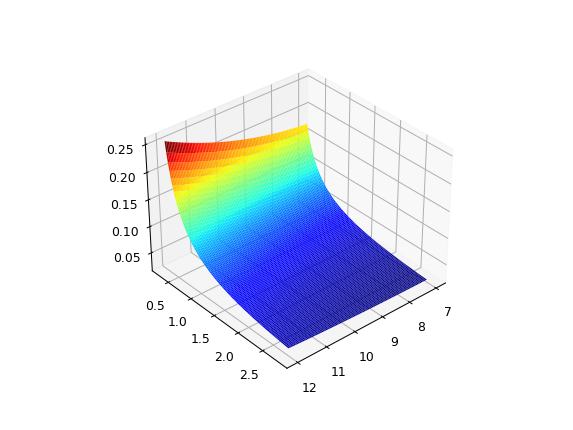

In [5]:
# Wizualizacja funkcji celu
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(7, 12, 100)
y = np.linspace(0.32, 2.8, 100)

X, Y = np.meshgrid(x, y)

def  f(x,y):
        return k / y * ((3 / x * t_D) + (4 * t_d[1]) + (8 * x ** 3 * k * t_n / G_spr))

Z = f(X,Y)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=1, cstride=1,cmap='jet', edgecolor = 'none')

plt.show()

# Wnioski
* otrzymane wyniki c=7, d=2, n=19,4 są wiarygodne
* optymalizator SLSQP jest genialnym narzędziem do tego typu zadań, niestety nie udało mi się zaimplementować go w pełnej jego okazałości. Czyli bez użycia Warunku na K w celu minimalizacji funkcji celu, a podaniu na wejściu funckji 3 zmiennych i dodaniu, nieużytego w kodzie choć napisanego warunku na równość tych 3 zmiennych. Napotkałem dośc duże problemy (podejżewam) związane z wpadaniem algorytmu w lokalne minima i wysoką zależność od punktu startowego.
* Problem kwantyfikacji zmiennej d w tym przypadku jest rozwiązany, gdyż wynikiem jest d bliskie 2. W innym wypadku można stosować przybliżenie do najbliższej ustandaryzowanej wartości po obliczeniach, lub użycie wbudowanej w algorytm funkcji która może wybierać zmienne dyskretne, niestety nie udało mi się jej zaimplementować.